In [1]:
import testing as t
from matplotlib import pyplot as plt

## Fine tuning poem model on poems

In [ ]:
!python fine_tune.py \
    --dataset_name Ozziey/poems_dataset\
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --do_train \
    --do_eval \
    --output_dir ./tmp/poem_baseline \
    --overwrite_output_dir

## Fine tuning on Joy poems
https://huggingface.co/docs/transformers/v4.27.1/en/main_classes/trainer#transformers.TrainingArguments

In [ ]:
!python fine_tune.py \
    --dataset_name Ozziey/poems_dataset\
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --do_train \
    --do_eval \
    --num_train_epochs 50 \
    --seed 19019509 \
    --output_dir ./tmp/joy_poem_baseline \
    --overwrite_output_dir \
    --joy

## Finetune on PERC data
1. get data from: https://data.mendeley.com/datasets/n9vbc8g9cx/1
2. convert by running joy_data_loader.py
3. run following script

In [ ]:
!python fine_tune.py \
    --train_file ./Data/PERC.csv\
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --do_train \
    --do_eval \
    --num_train_epochs 50 \
    --seed 19019509 \
    --output_dir ./tmp/perc_poem_baseline \
    --overwrite_output_dir \
    --joy

## Generation

In [ ]:
K=50
# change model path to the saved directory
!python text_generation.py \
    --model_type gpt2 \
    --model_name_or_path ./tmp/perc_poem_baseline \
    --length 50 \
    --prompt "Spring" \
    --seed 200 \
    --k $K \
    --num_return_sequences 500

In [3]:
rate, rates = t.fluency(verbose=0)

500


0.9782482934166378


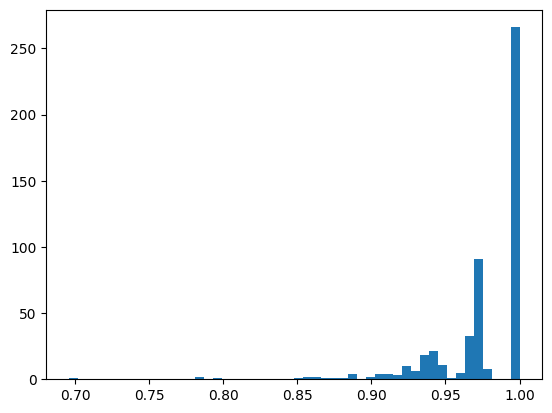

In [4]:
print(rate)
plt.close()
plt.figure()
plt.hist(rates, bins=50)
plt.show()
